# Pipeline for High-z Radio Galaxies 12: Application of full pipeline for prediction

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd
import mpl_scatter_density
# import schemdraw
# from schemdraw import flow

In [2]:
mpl.rcdefaults()

Create path effects.

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

Define specific metrics for redshift values.

In [4]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [5]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [6]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [7]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [8]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methods for Pycaret and saved models.

In [9]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [10]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

Methods for the use of values in Confusion Matrices.

In [11]:
def MCC_from_CM(cm_array):  # Matthews correlation coefficient
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    MCC = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return MCC

In [12]:
def ACC_from_CM(cm_array):  # Accuracy
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    ACC = (TP + TN) / (TP + TN + FP + FN)
    return ACC

In [13]:
def F1_from_CM(cm_array):  # F-1 score
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    F1 = 2 * TP / (2 * TP + FP + FN)
    return F1

In [14]:
def Recall_from_CM(cm_array):  # Recall
    TN, FP, FN, TP = cm_array.flatten().astype('float32')
    Recall = TP / (TP + FN)
    return Recall

Method to plot confusion matrix

In [15]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal', values_format=',')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(28)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

Method to plot predicted and true redshift values

In [16]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.5))

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=1., right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=1., top=np.ceil(max_for_range))
    ax_pre.set_title(title)
    plt.tight_layout()

---

## Reading data

In [17]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

Flags.

In [18]:
save_plot_flag      = True
load_models_flag    = True
use_second_z_model  = True
use_third_z_model   = True
use_fourth_z_model  = True
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017

In [19]:
used_area           = 'COSMOS'  # can be 'S82', 'HETDEX', 'COSMOS'

In [20]:
if used_area != 'S82':
    compare_A17_flag = False

In [21]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_S82_Ananna_17  = f'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_Ananna_17_zsp_5sigma_imp.h5'  # 204 objects

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [22]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [23]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [24]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Create features with class and combined redshift.

In [25]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
filter_non_confirmed                = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) | np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [26]:
full_catalog_df['radio_AGN']      = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

Discard minor features.

In [27]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

##### Random seed

In [28]:
seed                                = 42

---

### Load models

In [29]:
if load_models_flag:
    AGN_gal_clf     = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')
    radio_det_clf   = pyc.load_model('models/classification_radio_detect_may_16_2022')
    redshift_reg    = pyr.load_model('models/regression_z_may_17_2022')  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model('models/regression_z_may_18_2022')  # to use on sources with predicted z >= 2
    if use_third_z_model:
        redshift_reg_3  = pyr.load_model('models/regression_z_may_30_2022')  # to use on sources with predicted z >= 3
    if use_fourth_z_model:
        redshift_reg_4  = pyr.load_model('models/regression_z_may_31_2022')  # to use on sources with predicted z >= 3.7 (for z >= 4, regression_z_may_31_4_2022)

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [30]:
threshold_AGN   = 0.5
threshold_radio = 0.5

In [31]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})

In [32]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})

In [33]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=3)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [34]:
redshift_lim_a    = 2.0
redshift_tol_a    = 0.0
redshift_lim_b    = 3.0
redshift_tol_b    = 0.0
redshift_lim_c    = 3.7
redshift_tol_c    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=3)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_a + redshift_tol_a)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)
if use_third_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_3, data=full_catalog_df, round=3)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_b + redshift_tol_b)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)
if use_fourth_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_4, data=full_catalog_df, round=3)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim_c + redshift_tol_c)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

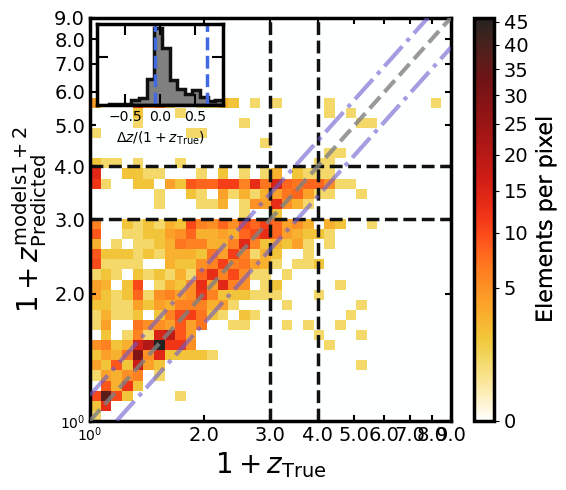

In [35]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + redshift_lim_a), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim_a), ls='--', c='k', lw=2.5)
ax1.axvline(x=(1 + redshift_lim_b), ls='--', c='k', lw=2.5)
ax1.axhline(y=(1 + redshift_lim_b), ls='--', c='k', lw=2.5)
if use_second_z_model:
    ax1.set_ylabel('$1 + z_{\mathrm{Predicted}}^{\mathrm{models}1+2}$', size=20)
plt.show()

In [36]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

In [37]:
full_catalog_df.loc[:, ['class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,72120.000000,72120.000000,72120.000000,72120.000000,1538.000000,72120.000000
mean,0.404167,0.180921,0.123197,0.192083,0.986922,2.119317
std,0.216453,0.384955,0.328666,0.393940,0.844989,1.033281
min,0.000000,0.000000,0.000000,0.000000,-0.000310,0.043000
25%,0.500000,0.000000,0.000000,0.000000,0.350080,1.488750
50%,0.500000,0.000000,0.000000,0.000000,0.769500,1.989000
75%,0.500000,0.000000,0.000000,0.000000,1.457500,2.563000
max,1.000000,1.000000,1.000000,1.000000,7.149000,4.866000


Obtain intermediate metrics

In [38]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
filter_gal_AGN_t        = np.array(full_catalog_df.loc[:, 'class'] == 0) | np.array(full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0))
num_radio_t             = np.sum(np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [39]:
# filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'Score_AGN']          >= threshold_AGN) &\
#                             np.array(full_catalog_df.loc[:, 'Score_radio']      >= threshold_radio)
filter_radio_AGN_p      = np.array(full_catalog_df.loc[:, 'pred_class']      == 1) &\
                            np.array(full_catalog_df.loc[:, 'pred_radio']    == 1)
filter_AGN_p            = np.array(full_catalog_df.loc[:, 'pred_class']      == 1)
filter_radio_p          = np.array(full_catalog_df.loc[:, 'pred_radio']      == 1)
num_AGN_p               = np.sum(filter_AGN_p)
num_gal_p               = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0))
num_radio_p             = np.sum(filter_radio_p)
num_radio_AGN_p         = np.sum(filter_radio_AGN_p)

Confusion matrix for AGN prediction on confirmed sources (AGN/galaxies)

In [40]:
cm_AGN = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0) & np.array(full_catalog_df.loc[:, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0) & np.array(full_catalog_df.loc[:, 'pred_class'] >= 1))],\
                   [np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'pred_class'] == 0)),\
                    np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'pred_class'] == 1))]])

Confusion matrix for AGN prediction on all sources (AGN/galaxies + unknown)

In [41]:
cm_AGN_large = np.array([[np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0)   & np.array(full_catalog_df.loc[:, 'pred_class'] == 0)),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0)   & np.array(full_catalog_df.loc[:, 'pred_class'] == 0.5)),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0)   & np.array(full_catalog_df.loc[:, 'pred_class'] == 1))],\
                         [np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0.5) & np.array(full_catalog_df.loc[:, 'pred_class'] == 0)),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0.5) & np.array(full_catalog_df.loc[:, 'pred_class'] == 0.5)),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 0.5) & np.array(full_catalog_df.loc[:, 'pred_class'] == 1))],\
                         [np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1)   & np.array(full_catalog_df.loc[:, 'pred_class'] == 0)),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1)   & np.array(full_catalog_df.loc[:, 'pred_class'] == 0.5)),\
                          np.sum(np.array(full_catalog_df.loc[:, 'class'] == 1)   & np.array(full_catalog_df.loc[:, 'pred_class'] == 1))]])

Confusion matrix for radio detection prediction on confirmed sources (AGN/galaxies)

In [42]:
cm_radio_conf = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 0) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio']   == 0)),\
                           np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 0) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio']   == 1))],\
                          [np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 1) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio']   == 0)),\
                           np.sum(np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'radio_detect'] == 1) &\
                                  np.array(full_catalog_df.loc[filter_AGN_p & filter_gal_AGN_t, 'pred_radio']   == 1))]])

Confusion matrix for radio detection prediction on all sources (AGN/galaxies + unknown)

In [43]:
cm_radio = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))],\
                     [np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))]])

Confusion matrix for radio AGN prediction on confirmed sources (AGN/galaxies)

In [44]:
cm_radio_AGN_conf = np.array([[np.sum(np.array(full_catalog_df.loc[filter_gal_AGN_t, 'radio_AGN'] == 0) &\
                                      np.array(full_catalog_df.loc[filter_gal_AGN_t,'pred_radio_AGN'] == 0)),\
                               np.sum(np.array(full_catalog_df.loc[filter_gal_AGN_t, 'radio_AGN'] == 0) &\
                                      np.array(full_catalog_df.loc[filter_gal_AGN_t,'pred_radio_AGN'] == 1))],\
                              [np.sum(np.array(full_catalog_df.loc[filter_gal_AGN_t, 'radio_AGN'] == 1) &\
                                      np.array(full_catalog_df.loc[filter_gal_AGN_t,'pred_radio_AGN'] == 0)),\
                               np.sum(np.array(full_catalog_df.loc[filter_gal_AGN_t, 'radio_AGN'] == 1) &\
                                      np.array(full_catalog_df.loc[filter_gal_AGN_t,'pred_radio_AGN'] == 1))]])

Confusion matrix for radio AGN prediction on all sources (AGN/galaxies + unknown)

In [45]:
cm_radio_AGN = np.array([[np.sum(np.array(full_catalog_df['radio_AGN'] == 0) & np.array(full_catalog_df['pred_radio_AGN'] == 0)),\
                          np.sum(np.array(full_catalog_df['radio_AGN'] == 0) & np.array(full_catalog_df['pred_radio_AGN'] == 1))],\
                         [np.sum(np.array(full_catalog_df['radio_AGN'] == 1) & np.array(full_catalog_df['pred_radio_AGN'] == 0)),\
                          np.sum(np.array(full_catalog_df['radio_AGN'] == 1) & np.array(full_catalog_df['pred_radio_AGN'] == 1))]])

In [46]:
sigma_mad_field            = sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

Plot histograms for scores.

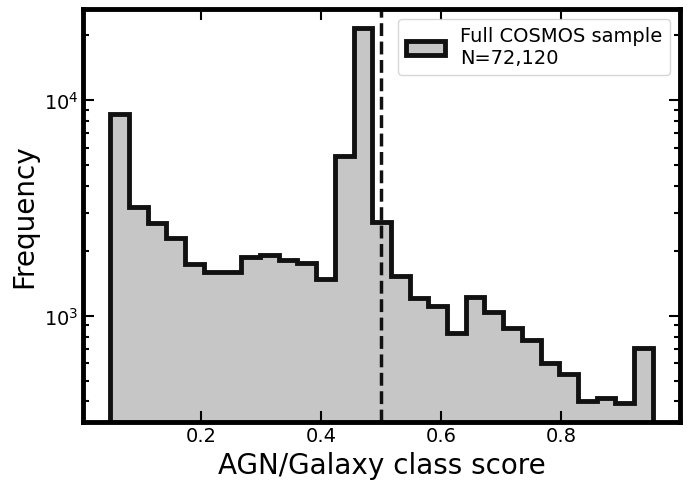

In [47]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(np.isfinite(full_catalog_df.loc[:, 'Score_AGN']))

ax1.hist(full_catalog_df.loc[:, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Full {used_area} sample\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_AGN_scores_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

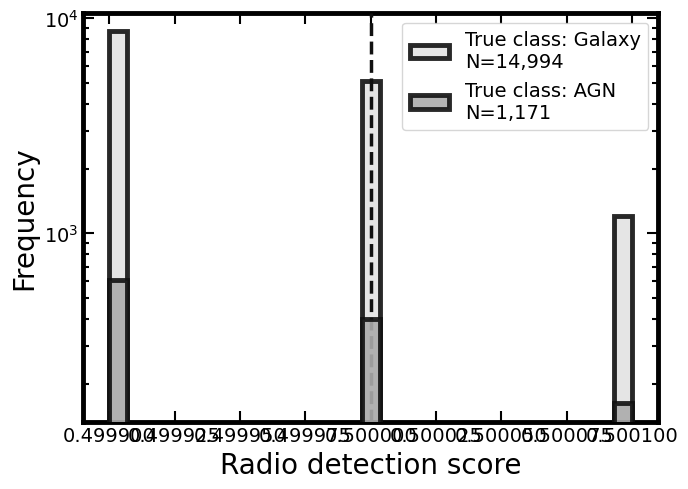

In [48]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_scores_true_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

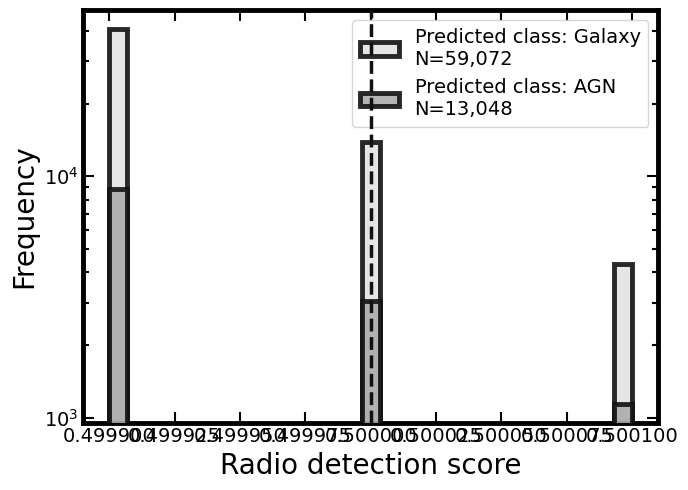

In [49]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Score_radio']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Score_radio']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Score_radio'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Score_radio'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5, zorder=9)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_radio_scores_predicted_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

Plot histograms for predicted and original redshifts.

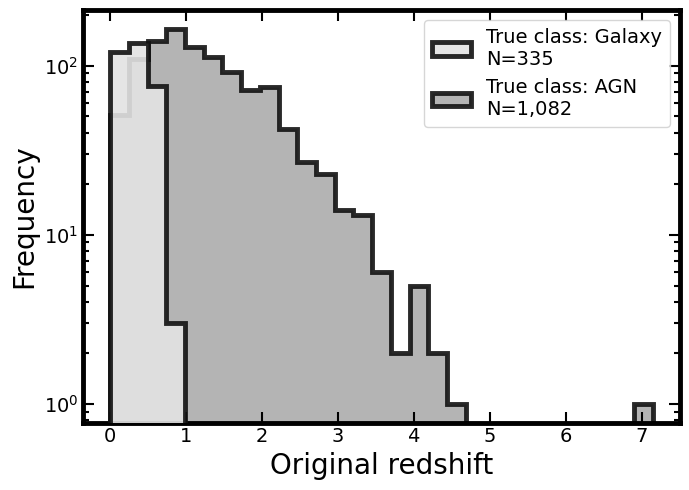

In [50]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Original redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_original_redshift_true_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

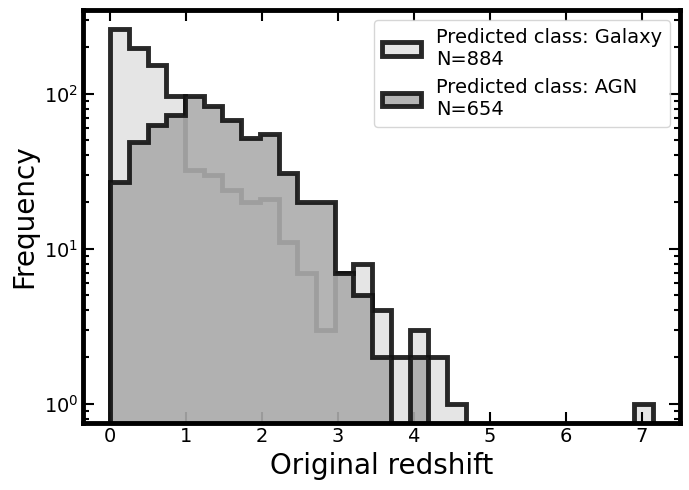

In [51]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] <  threshold_AGN), 'Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Original redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_true_redshift_predicted_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

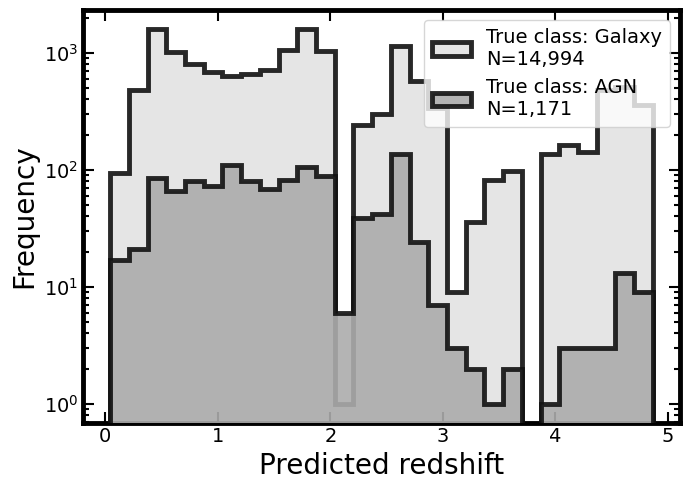

In [52]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'pred_Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'pred_Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 0), 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'True class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'class'] == 1), 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'True class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_redshift_true_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

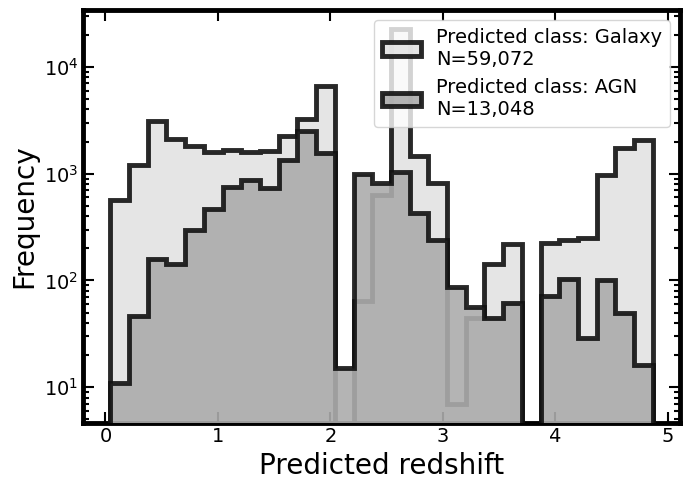

In [53]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[:, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[:, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size_gal = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'pred_Z']))
sample_size_AGN = np.sum(np.isfinite(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'pred_Z']))

ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] < threshold_AGN), 'pred_Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
         label=f'Predicted class: Galaxy\nN={sample_size_gal:,}', zorder=np.ceil((sample_size_AGN/sample_size_gal)))
ax1.hist(full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'Score_AGN'] >= threshold_AGN), 'pred_Z'],\
         bins=score_bins, histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.7), alpha=0.9,\
         label=f'Predicted class: AGN\nN={sample_size_AGN:,}', zorder=np.ceil((sample_size_gal/sample_size_AGN)))
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(f'plots/hist_predicted_redshift_predicted_class_{used_area}.pdf', bbox_inches='tight')
fig.tight_layout()

### Select sources predicted to be Radio AGN

In [54]:
full_catalog_df         = full_catalog_df.loc[filter_radio_AGN_p]

In [55]:
full_catalog_df.loc[:, ['class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']].describe()

,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,2628.000000,2628.0,2628.000000,2628.0,191.000000,2628.000000
mean,0.488204,1.0,0.333333,1.0,1.079613,1.488206
std,0.209804,0.0,0.471494,0.0,0.683307,0.639237
min,0.000000,1.0,0.000000,1.0,-0.000020,0.049000
25%,0.500000,1.0,0.000000,1.0,0.519000,1.065750
50%,0.500000,1.0,0.000000,1.0,1.008000,1.344000
75%,0.500000,1.0,1.000000,1.0,1.452000,1.889000
max,1.000000,1.0,1.000000,1.0,4.183000,4.750000


Add individual metrics for redshift

In [56]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [57]:
str_0_t   = f'Out of {total_size:,} initial sources in {used_area},\n'
str_1_t   = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t   = f'{num_AGN_t:,} are confirmed to be AGN. And, from the AGN,\n'
str_3_t   = f'{num_radio_AGN_t:,} are detected in radio.'

str_0_p   = f'Out of {num_radio_AGN_t:,} initial radio-detected AGN in {used_area},\n'
str_1_p   = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_p   = f'{num_AGN_p:,} are predicted to be AGN. And, from the predicted AGN,\n'
str_3_p   = f'{num_radio_AGN_p:,} are predicted to be detected in radio.'

In [58]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)
print(str_0_p + str_1_p + str_2_p + str_3_p)
print('-' * 60)

------------------------------------------------------------
Out of 72,120 initial sources in COSMOS,
14,994 are confirmed to be galaxies. On the other side,
1,171 are confirmed to be AGN. And, from the AGN,
569 are detected in radio.
------------------------------------------------------------
Out of 569 initial radio-detected AGN in COSMOS,
59,072 are predicted to be galaxies. On the other side,
13,048 are predicted to be AGN. And, from the predicted AGN,
2,628 are predicted to be detected in radio.
------------------------------------------------------------


In [59]:
cols_4_table = show_columns = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z', 'Delta_z_N']

In [60]:
filter_new_rAGN = full_catalog_df.loc[:, 'radio_AGN'] == 0

In [61]:
display(full_catalog_df.loc[filter_new_rAGN, cols_4_table].sort_values(by='pred_Z', ascending=False).head(15))

,RA_ICRS,DE_ICRS,Name,TYPE,band_num,class,pred_class,radio_detect,pred_radio,Z,pred_Z,Delta_z_N
60417,150.001007,2.730180,J100000.24+024348.6,,11,0.5,1,0,1,NaN,4.750,NaN
49677,149.621231,2.052233,J095829.09+020308.0,,11,0.5,1,0,1,NaN,4.719,NaN
45910,150.384506,1.765586,J100132.28+014556.1,,11,0.5,1,0,1,NaN,4.689,NaN
68636,149.913223,1.897090,J095939.17+015349.5,,11,0.5,1,0,1,NaN,4.666,NaN
24445,149.622772,2.512260,J095829.46+023044.1,,11,0.5,1,0,1,NaN,4.643,NaN
9096,149.964584,1.862053,J095951.50+015143.4,,14,0.5,1,0,1,NaN,4.640,NaN
63514,150.395187,1.488628,J100134.84+012919.0,,14,0.5,1,0,1,NaN,4.617,NaN
66173,149.296829,1.752855,J095711.24+014510.2,,12,0.5,1,0,1,NaN,4.617,NaN
4065,150.072098,1.473804,J100017.30+012825.7,,11,0.5,1,0,1,NaN,4.616,NaN
65106,150.479553,1.996056,J100155.09+015945.8,,14,0.5,1,0,1,NaN,4.606,NaN


In [62]:
display(full_catalog_df.loc[filter_new_rAGN, cols_4_table].sort_values(by='Z', ascending=False).head(10))

,RA_ICRS,DE_ICRS,Name,TYPE,band_num,class,pred_class,radio_detect,pred_radio,Z,pred_Z,Delta_z_N
2363,150.732498,1.516130,J100255.80+013058.0,Q,8,1.0,1,0,1,4.183,0.909,-0.632
58975,150.717102,1.930054,J100252.10+015548.2,QX,6,1.0,1,0,1,3.567,1.069,-0.547
61697,150.616577,2.482969,J100227.98+022858.6,QX,6,1.0,1,0,1,2.746,1.840,-0.242
57303,150.593903,2.801251,J100222.54+024804.4,QX,15,1.0,1,0,1,2.593,2.566,-0.008
6209,150.182968,2.247883,J100043.91+021452.3,QX,6,1.0,1,0,1,2.472,1.321,-0.332
57026,149.744598,2.027437,J095858.70+020138.7,QX,11,1.0,1,0,1,2.455,2.422,-0.010
55239,150.360077,1.937048,J100126.42+015613.3,Q,6,1.0,1,0,1,2.377,1.989,-0.115
61765,150.420639,1.945289,J100140.95+015643.0,QX,16,1.0,1,0,1,2.180,1.828,-0.111
39463,150.402039,2.884370,J100136.49+025303.7,QX,12,1.0,1,0,1,2.117,1.849,-0.086
57322,149.524246,2.942713,J095805.82+025633.7,X,11,1.0,1,0,1,2.100,1.712,-0.125


Confusion matrix for AGN/galaxy prediction on all sources

In [63]:
MCC_AGN              = MCC_from_CM(cm_AGN)
ACC_AGN              = ACC_from_CM(cm_AGN)
F1_AGN               = F1_from_CM(cm_AGN)
Recall_AGN           = Recall_from_CM(cm_AGN)

Confusion matrix for radio detection prediction on all predicted AGN

In [64]:
MCC_radio            = MCC_from_CM(cm_radio)
ACC_radio            = ACC_from_CM(cm_radio)
F1_radio             = F1_from_CM(cm_radio)
Recall_radio         = Recall_from_CM(cm_radio)

Confusion matrix for radio detection prediction on all confirmed sources

In [65]:
MCC_radio_conf       = MCC_from_CM(cm_radio_conf)
ACC_radio_conf       = ACC_from_CM(cm_radio_conf)
F1_radio_conf        = F1_from_CM(cm_radio_conf)
Recall_radio_conf    = Recall_from_CM(cm_radio_conf)

Confusion matrix for radio AGN detection prediction.

In [66]:
MCC_radio_AGN        = MCC_from_CM(cm_radio_AGN)
ACC_radio_AGN        = ACC_from_CM(cm_radio_AGN)
F1_radio_AGN         = F1_from_CM(cm_radio_AGN)
Recall_radio_AGN     = Recall_from_CM(cm_radio_AGN)

Confusion matrix for radio AGN detection prediction on confirmed sources.

In [67]:
MCC_radio_AGN_conf    = MCC_from_CM(cm_radio_AGN_conf)
ACC_radio_AGN_conf    = ACC_from_CM(cm_radio_AGN_conf)
F1_radio_AGN_conf     = F1_from_CM(cm_radio_AGN_conf)
Recall_radio_AGN_conf = Recall_from_CM(cm_radio_AGN_conf)

Print metrics

In [68]:
print('Metrics for AGN prediction on all sources')
print(f'Sample size,                        N = {np.sum(filter_gal_AGN_t):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_AGN:.4f}')
print(f'F-1 Score,                         F1 = {F1_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_AGN:.4f}')

Metrics for AGN prediction on all sources
Sample size,                        N = 16,165
Matthews Correlation Coefficient, MCC = 0.2002
Accuracy,                         ACC = 0.7411
F-1 Score,                         F1 = 0.2485
Recall,                        Recall = 0.5909


In [69]:
print('Metrics for radio detection prediction on all predicted AGN')
print(f'Sample size,                        N = {np.sum(filter_AGN_p):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio:.4f}')
print(f'Recall,                        Recall = {Recall_radio:.4f}')

Metrics for radio detection prediction on all predicted AGN
Sample size,                        N = 13,048
Matthews Correlation Coefficient, MCC = 0.2362
Accuracy,                         ACC = 0.7722
F-1 Score,                         F1 = 0.3709
Recall,                        Recall = 0.4179


In [70]:
print('Metrics for radio detection prediction on all confirmed sources predicted to be AGN')
print(f'Sample size,                        N = {np.sum(filter_AGN_p & filter_gal_AGN_t):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_conf:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_conf:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_conf:.4f}')
print(f'Recall,                        Recall = {Recall_radio_conf:.4f}')

Metrics for radio detection prediction on all confirmed sources predicted to be AGN
Sample size,                        N = 4,398
Matthews Correlation Coefficient, MCC = 0.3516
Accuracy,                         ACC = 0.8397
F-1 Score,                         F1 = 0.4245
Recall,                        Recall = 0.3417


In [71]:
print('Metrics for radio AGN detection prediction')
print(f'Sample size,                        N = {total_size:,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_AGN:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_AGN:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_AGN:.4f}')
print(f'Recall,                        Recall = {Recall_radio_AGN:.4f}')

Metrics for radio AGN detection prediction
Sample size,                        N = 72,120
Matthews Correlation Coefficient, MCC = 0.1115
Accuracy,                         ACC = 0.9599
F-1 Score,                         F1 = 0.0963
Recall,                        Recall = 0.2707


In [72]:
print('Metrics for radio AGN detection prediction on all confirmed sources')
print(f'Sample size,                        N = {np.sum(filter_gal_AGN_t):,}')
print(f'Matthews Correlation Coefficient, MCC = {MCC_radio_AGN_conf:.4f}')
print(f'Accuracy,                         ACC = {ACC_radio_AGN_conf:.4f}')
print(f'F-1 Score,                         F1 = {F1_radio_AGN_conf:.4f}')
print(f'Recall,                        Recall = {Recall_radio_AGN_conf:.4f}')

Metrics for radio AGN detection prediction on all confirmed sources
Sample size,                        N = 16,165
Matthews Correlation Coefficient, MCC = 0.2768
Accuracy,                         ACC = 0.9552
F-1 Score,                         F1 = 0.2982
Recall,                        Recall = 0.2707


In [73]:
print('Metrics for redshift prediction on all predicted radio AGN')
print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_df.loc[:, "Z"]) & np.isfinite(full_catalog_df.loc[:, "pred_Z"])):,}')
print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_field:.4f}')
print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_field:.4f}')
print(f'Sigma z,                          \u03C3 z = {sigma_z_field:.4f}')
print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_field:.4f}')
print(f'Outlier fraction,                   \u03B7 = {out_frac_field:.4f}')

Metrics for redshift prediction on all predicted radio AGN
Sample size,                        N = 191
Sigma MAD                       σ MAD = 0.2886
Sigma NMAD,                    σ NMAD = 0.1480
Sigma z,                          σ z = 0.1677
Sigma z normalized,             σ z N = 0.1050
Outlier fraction,                   η = 0.3822


Plot predictions

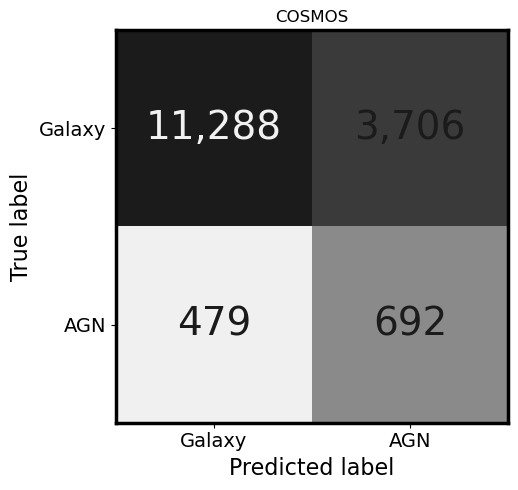

In [74]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

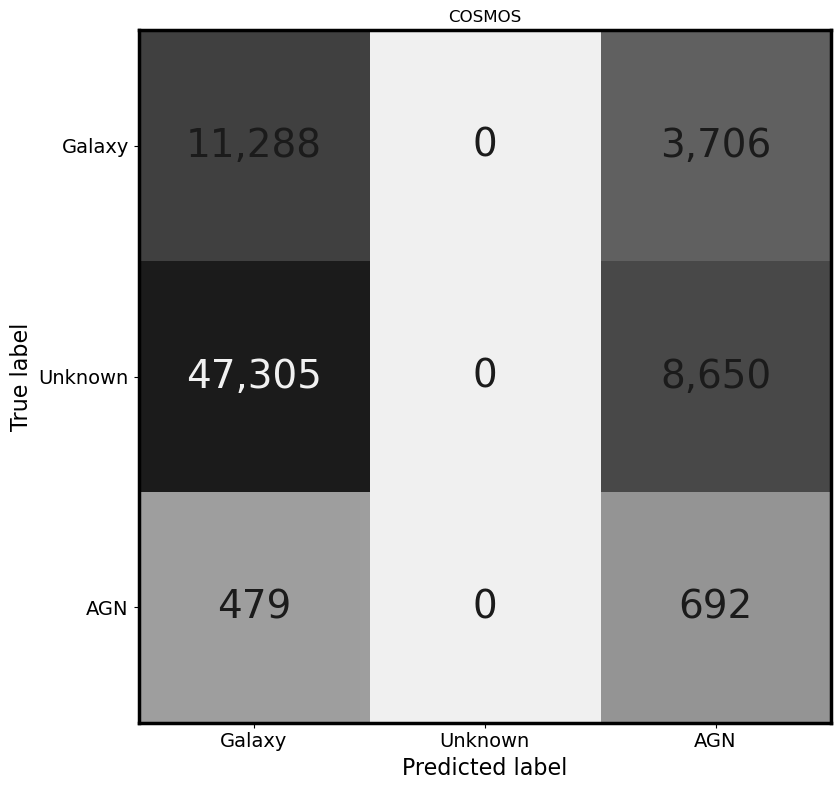

In [75]:
fig             = plt.figure(figsize=(9,8))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_AGN_large, title=used_area, axin=ax1, display_labels=['Galaxy', 'Unknown', 'AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_AGN_all_classes_{used_area}.pdf', bbox_inches='tight')
plt.show()

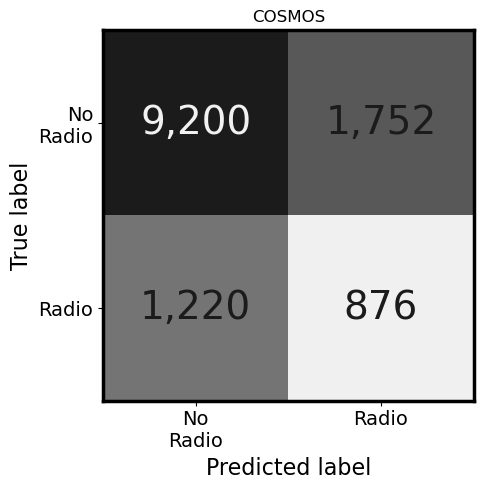

In [76]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_{used_area}.pdf', bbox_inches='tight')
plt.show()

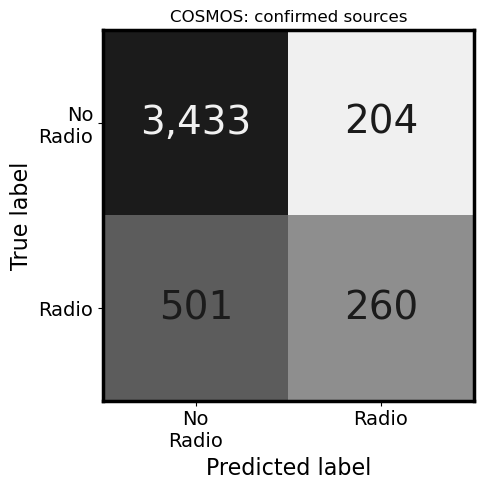

In [77]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio_conf, title=used_area+': confirmed sources', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_confirmed_{used_area}.pdf', bbox_inches='tight')
plt.show()

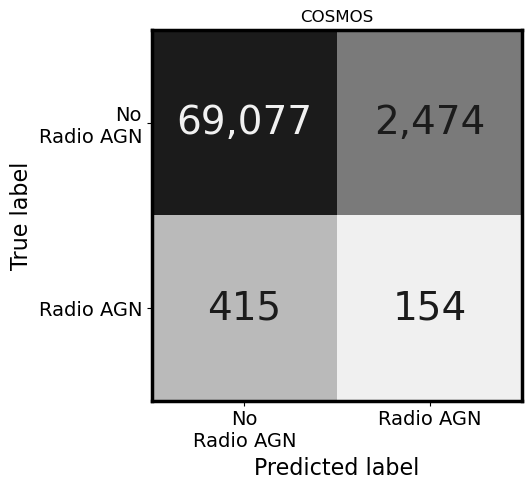

In [78]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio_AGN, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

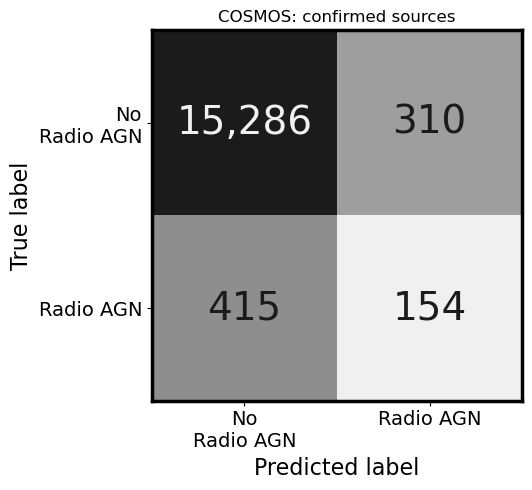

In [79]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
plot_conf_mat(cm_radio_AGN_conf, title=used_area + ': confirmed sources', axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=True)
if save_plot_flag:
    plt.savefig(f'plots/conf_matrix_radio_AGN_confirmed_{used_area}.pdf', bbox_inches='tight')
plt.show()

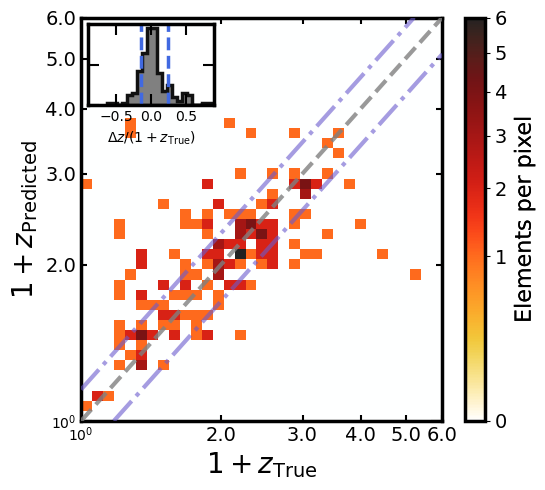

In [80]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'], ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(f'plots/compare_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

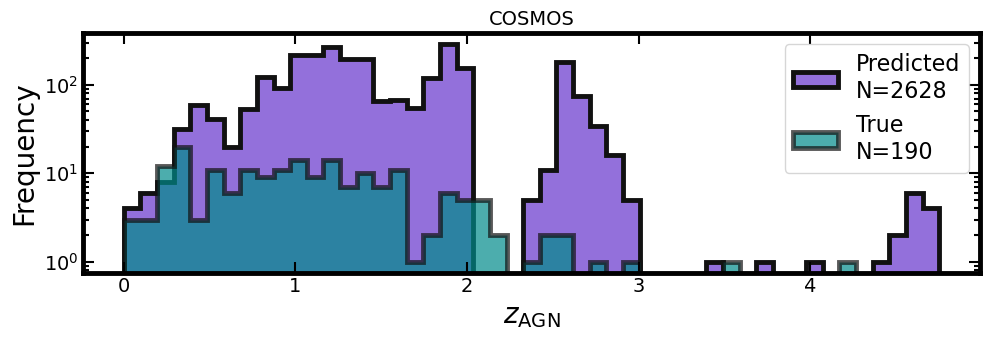

In [81]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(full_catalog_df.loc[:, 'Z']),\
                           np.nanmin(full_catalog_df.loc[:, 'pred_Z'])])
max_for_range = np.nanmax([np.nanmax(full_catalog_df.loc[:, 'Z']),\
                           np.nanmax(full_catalog_df.loc[:, 'pred_Z'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(full_catalog_df.loc[:, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(full_catalog_df.loc[:, 'pred_Z'] > 0))}")
ax1.hist(full_catalog_df.loc[:, 'Z'], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(full_catalog_df.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(f'plots/hist_true_predicted_z_{used_area}.pdf')
plt.show()

---

## Additional test with data from Ananna et al., 2017

In [82]:
if compare_A17_flag:
    full_catalog_A17_df = pd.read_hdf(cat_path + file_S82_Ananna_17, key='df').drop(columns=features_2_discard)

In [83]:
if compare_A17_flag:
    full_catalog_A17_df = pyr.predict_model(redshift_reg, data=full_catalog_A17_df, round=3)
    full_catalog_A17_df = full_catalog_A17_df.rename(columns={'Label': 'pred_Z', 'is_AGN': 'class'})
    full_catalog_A17_df['pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=3)
    redshift_lim_0    = 2.0
    redshift_tol_0    = 0.0
    redshift_lim_1    = 3.0
    redshift_tol_1    = 0.0
    redshift_lim_2    = 3.7
    redshift_tol_2    = 0.0
    if use_second_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_2, data=full_catalog_A17_df, round=3)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_0 + redshift_tol_0)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=3)
    if use_third_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_3, data=full_catalog_A17_df, round=3)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_1 + redshift_tol_1)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=3)
    if use_fourth_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_4, data=full_catalog_A17_df, round=3)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (redshift_lim_2 + redshift_tol_2)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=3)

In [84]:
if compare_A17_flag:
    sigma_mad_AGN_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_AGN_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_AGN_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_AGN_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_AGN_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [85]:
if compare_A17_flag:
    print('Metrics for redshift prediction on AGN from Ananna et al., 2017')
    print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"])):,}')
    print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_AGN_A17:.4f}')
    print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_AGN_A17:.4f}')
    print(f'Sigma z,                          \u03C3 z = {sigma_z_AGN_A17:.4f}')
    print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_AGN_A17:.4f}')
    print(f'Outlier fraction,                   \u03B7 = {out_frac_AGN_A17:.4f}')

In [86]:
if compare_A17_flag:
    fig              = plt.figure(figsize=(7,5.0))
    ax1              = fig.add_subplot(111, xscale='linear', yscale='log')
    
    min_score        = np.nanmin([np.nanmin(full_catalog_A17_df.loc[:, 'zsp']), np.nanmin(full_catalog_A17_df.loc[:, 'pred_Z'])])
    max_score        = np.nanmax([np.nanmax(full_catalog_A17_df.loc[:, 'zsp']), np.nanmax(full_catalog_A17_df.loc[:, 'pred_Z'])])
    score_bins       = np.linspace(min_score, max_score, 30)
    
    sample_size_orig = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']))
    sample_size_pred = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    
    ax1.hist(full_catalog_A17_df.loc[:, 'zsp'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
             label=f'Original\nN={sample_size_orig:,}', zorder=2)
    ax1.hist(full_catalog_A17_df.loc[:, 'pred_Z'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
             label=f'Predicted\nN={sample_size_pred:,}', zorder=1)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    ax1.set_title('S82: Ananna+17')
    #ax1.set_aspect('equal', 'box')
    if save_plot_flag:
        plt.savefig(f'plots/hist_redshift_AGN_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    fig.tight_layout()

In [87]:
if compare_A17_flag:
    full_catalog_A17_df = full_catalog_A17_df.loc[np.array(full_catalog_A17_df.loc[:, 'class'] == 1) &\
                                                  np.array(full_catalog_A17_df.loc[:, 'radio_detect'] == 1)]

In [88]:
if compare_A17_flag:
    used_z_col = 'zsp'
    full_catalog_A17_df['Delta_z_N'] = np.around((full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                 (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)
    full_catalog_A17_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                  (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)

In [89]:
if compare_A17_flag:
    show_columns_A17 = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'class', 'radio_detect', 'Z', 'zsp', 'pred_Z', 'Delta_z_N']
    display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by='pred_Z', ascending=False).head(10))
    display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by=used_z_col, ascending=False).head(10))

In [90]:
if compare_A17_flag:
    sigma_mad_rAGN_A17            = sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_rAGN_A17           = sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_rAGN_A17              = sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_rAGN_A17         = sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_rAGN_A17             = outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [91]:
if compare_A17_flag:
    print('Metrics for redshift prediction on radio AGN from Ananna et al., 2017')
    print(f'Sample size,                        N = {np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"])):,}')
    print(f'Sigma MAD                       \u03C3 MAD = {sigma_mad_rAGN_A17:.4f}')
    print(f'Sigma NMAD,                    \u03C3 NMAD = {sigma_nmad_rAGN_A17:.4f}')
    print(f'Sigma z,                          \u03C3 z = {sigma_z_rAGN_A17:.4f}')
    print(f'Sigma z normalized,             \u03C3 z N = {sigma_z_norm_rAGN_A17:.4f}')
    print(f'Outlier fraction,                   \u03B7 = {out_frac_rAGN_A17:.4f}')

In [92]:
if compare_A17_flag:
    fig             = plt.figure(figsize=(6,5))
    ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
    plot_redshift_compare(full_catalog_A17_df.loc[:, used_z_col], full_catalog_A17_df.loc[:, 'pred_Z'],\
                          ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
    if save_plot_flag:
        plt.savefig(f'plots/compare_redshift_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()